In [1]:
# Importing the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV # Train Split and GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # ML Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor #
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures

Gathering Data

In [2]:
# Loading the Flight Price Prediction dataset from Kaggle
file_path = 'downloads/FlightPrediction/Clean_Dataset.csv'
flight_data = pd.read_csv(file_path)

# Dropping Unneccessary columns that may resemble Noise
flight_data.drop(columns=['Unnamed: 0'], inplace=True)

# Display the first few rows of the data
print(flight_data.head(20))

# Displaying Info
print(flight_data.info())

print(flight_data.describe())


      airline   flight source_city departure_time stops   arrival_time  \
0    SpiceJet  SG-8709       Delhi        Evening  zero          Night   
1    SpiceJet  SG-8157       Delhi  Early_Morning  zero        Morning   
2     AirAsia   I5-764       Delhi  Early_Morning  zero  Early_Morning   
3     Vistara   UK-995       Delhi        Morning  zero      Afternoon   
4     Vistara   UK-963       Delhi        Morning  zero        Morning   
5     Vistara   UK-945       Delhi        Morning  zero      Afternoon   
6     Vistara   UK-927       Delhi        Morning  zero        Morning   
7     Vistara   UK-951       Delhi      Afternoon  zero        Evening   
8    GO_FIRST   G8-334       Delhi  Early_Morning  zero        Morning   
9    GO_FIRST   G8-336       Delhi      Afternoon  zero        Evening   
10   GO_FIRST   G8-392       Delhi      Afternoon  zero        Evening   
11   GO_FIRST   G8-338       Delhi        Morning  zero      Afternoon   
12     Indigo  6E-5001       Delhi  Ea

In [3]:
# Checking for any missing values
flight_data.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

The model has none missing values which is ready for the next step

Data Visualization and Exploration

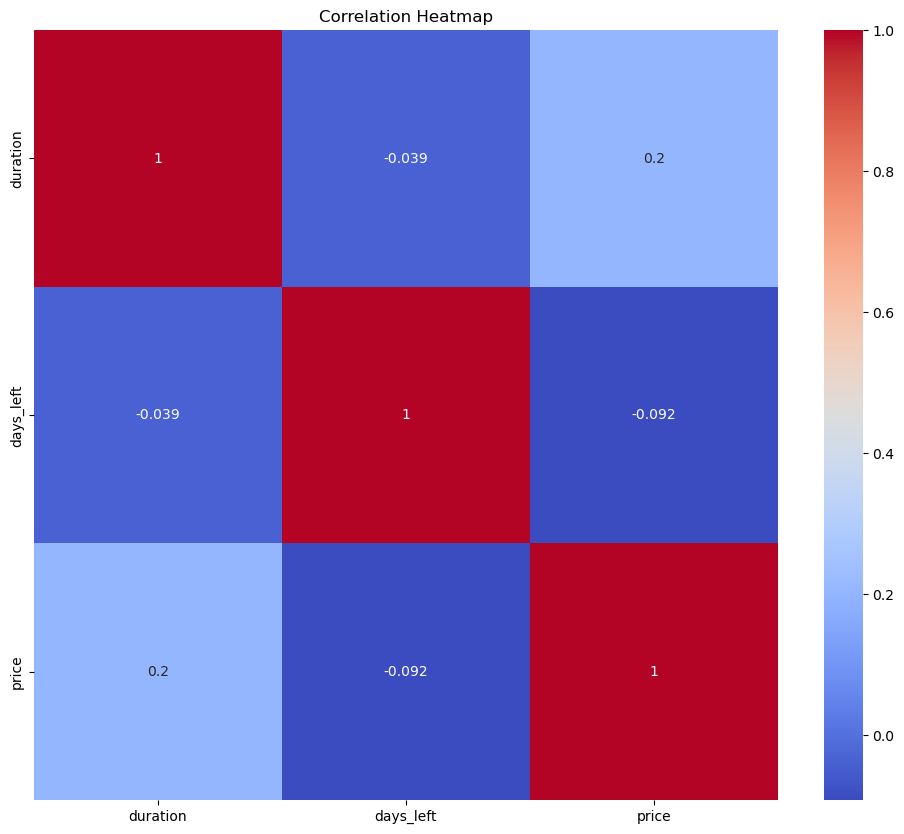

In [4]:
# Filter numerical columns only
numerical_data = flight_data.select_dtypes(include=['float64', 'int64'])

# Generate the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


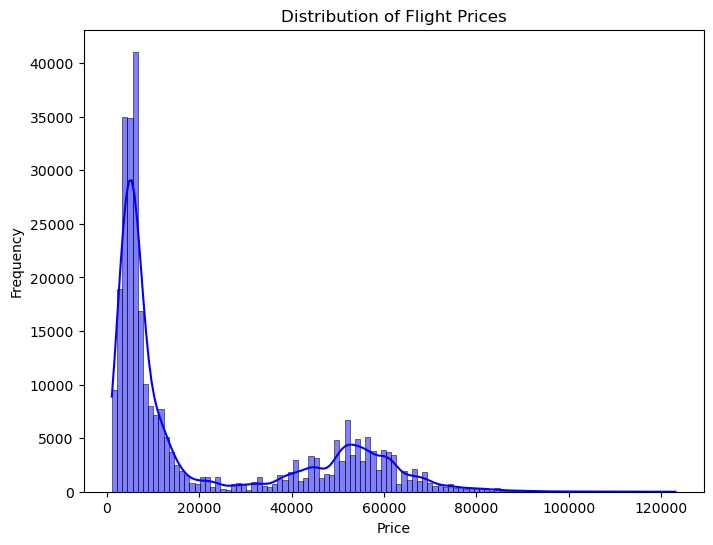

In [5]:
# Distribution of Flight Prices
plt.figure(figsize=(8, 6))
sns.histplot(flight_data['price'], kde=True, color='blue')
plt.title("Distribution of Flight Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

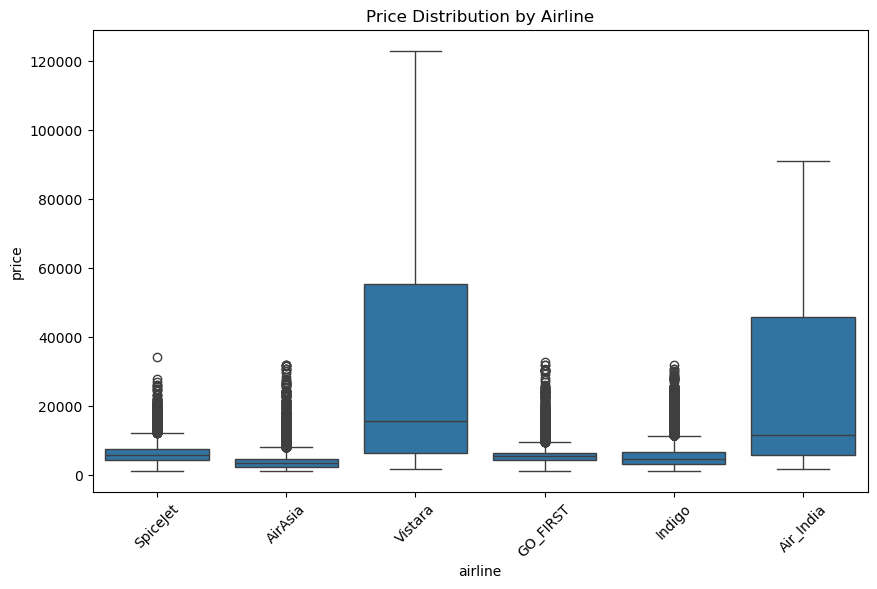

In [6]:
# Boxplot of The prices of the Airlines
plt.figure(figsize=(10, 6))
sns.boxplot(x='airline', y='price', data=flight_data)
plt.title("Price Distribution by Airline")
plt.xticks(rotation=45)
plt.show()

Data Processing

In [7]:
 # Define features and target
X = flight_data.drop(columns=['price'])
y = flight_data['price']

# Separate numerical and categorical columns
numerical_cols = ['duration', 'days_left']
categorical_cols = ['airline', 'source_city', 'departure_time', 'stops',
                    'arrival_time', 'destination_city', 'class']

# Preprocessing: Scaling numerical features, OneHotEncoding categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression Model

In [8]:
# Hyperparameter Tuning for Linear Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(score_func=f_regression)),
    ('model', LinearRegression())
])

param_grid = {
    'feature_selector__k': [5, 10, 'all'], 
    'preprocessor__num__with_mean': [True, False], 
    'preprocessor__num__with_std': [True, False],
}

grid_search_lr = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search_lr.fit(X_train, y_train)

# Using the best parameter
print("Best Parameters for Linear Regression:", grid_search_lr.best_params_)
print("Best MAE:", -grid_search_lr.best_score_)

best_linear_pipeline = grid_search_lr.best_estimator_


Best Parameters for Linear Regression: {'feature_selector__k': 'all', 'preprocessor__num__with_mean': False, 'preprocessor__num__with_std': True}
Best MAE: 4574.7692130701935


Linear Regression:
Train MAE: 4573.984927655247
Test MAE: 4553.28814507844
Train R2 Score: 0.911492578068169
Test R2 Score: 0.9113048689374478


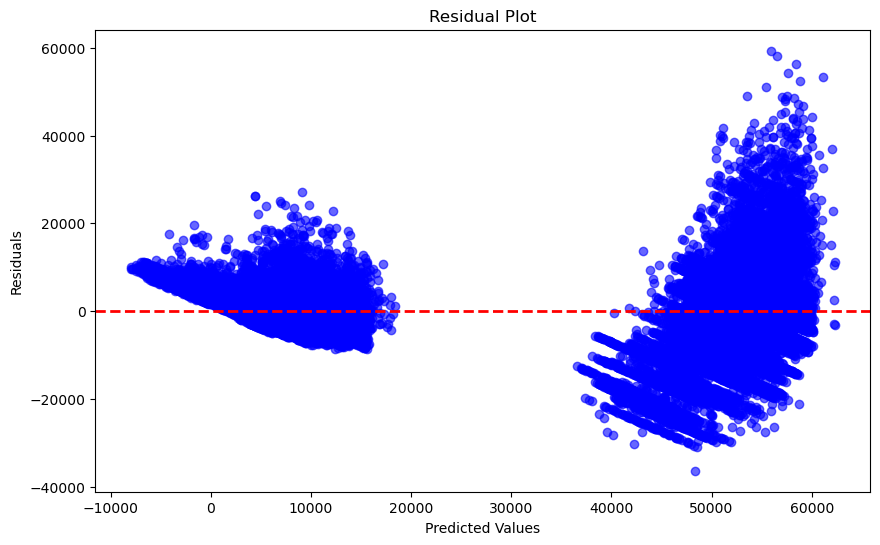

In [9]:
# Creating the Pipeline for Linear Regression

linear_pl = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Training
linear_pl.fit(X_train, y_train)
y_pred_train_lr = linear_pl.predict(X_train)
y_pred_test_lr = linear_pl.predict(X_test)

# Model Evaluation
lr_train_mae = mean_absolute_error(y_train, y_pred_train_lr)
lr_test_mae = mean_absolute_error(y_test, y_pred_test_lr)
lr_train_r2 = r2_score(y_train, y_pred_train_lr)
lr_test_r2 = r2_score(y_test, y_pred_test_lr)

print("Linear Regression:")
print(f"Train MAE: {lr_train_mae}")
print(f"Test MAE: {lr_test_mae}")
print(f"Train R2 Score: {lr_train_r2}")
print(f"Test R2 Score: {lr_test_r2}")

# Plotting a Residual Plot
residual_plot = y_test - y_pred_test_lr

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test_lr, residual_plot, alpha=0.6, color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


Random Forest

Training MAE: 2870.16
Test MAE: 2886.91
Training R2: 0.96
Test R2: 0.95


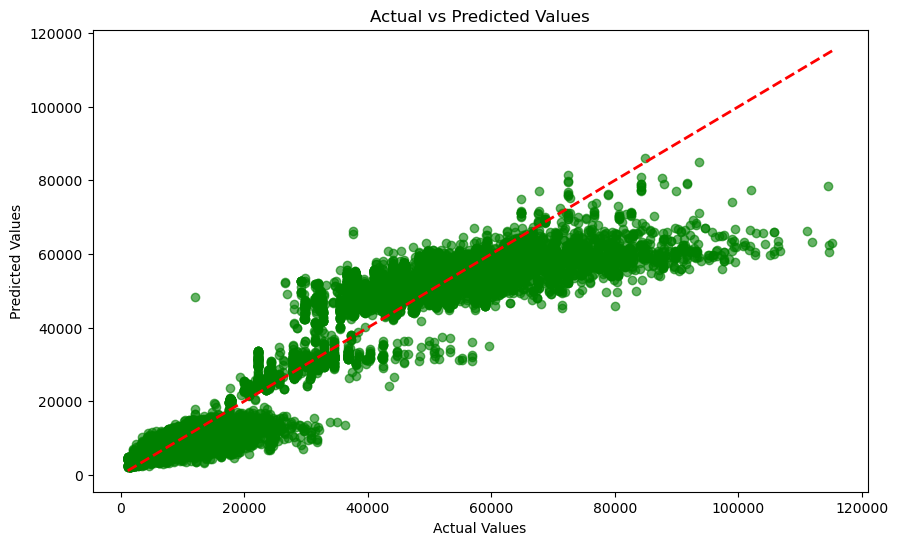

In [10]:
# Initializing Random Forest with optimized parameters
random_forest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=2, n_estimators=50, max_depth=10, max_features='sqrt'))
])

# I split the training set again into a smaller training set to train because for time optimization
X_train_sample = X_train.sample(frac=0.2, random_state=42)
y_train_sample = y_train[X_train_sample.index]

# Training the Random Forest Model by using the fit method
random_forest.fit(X_train_sample, y_train_sample)

# Training and Testing Predictions
y_pred_train_random_forest = random_forest.predict(X_train)
y_pred_test_random_forest = random_forest.predict(X_test)

# Model Evaluation
rf_train_mae = mean_absolute_error(y_train, y_pred_train_random_forest)
rf_test_mae = mean_absolute_error(y_test, y_pred_test_random_forest)
rf_train_r2 = r2_score(y_train, y_pred_train_random_forest)
rf_test_r2 = r2_score(y_test, y_pred_test_random_forest)

# Printing Accuracies
print(f"Training MAE: {rf_train_mae:.2f}")
print(f"Test MAE: {rf_test_mae:.2f}")
print(f"Training R2: {rf_train_r2:.2f}")
print(f"Test R2: {rf_test_r2:.2f}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_random_forest, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


Comaprison of the Models Visualized

               Model    Train MAE     Test MAE  Train R2   Test R2
0  Linear Regression  4573.984928  4553.288145  0.911493  0.911305
1      Random Forest  2870.164467  2886.909499  0.955518  0.954205


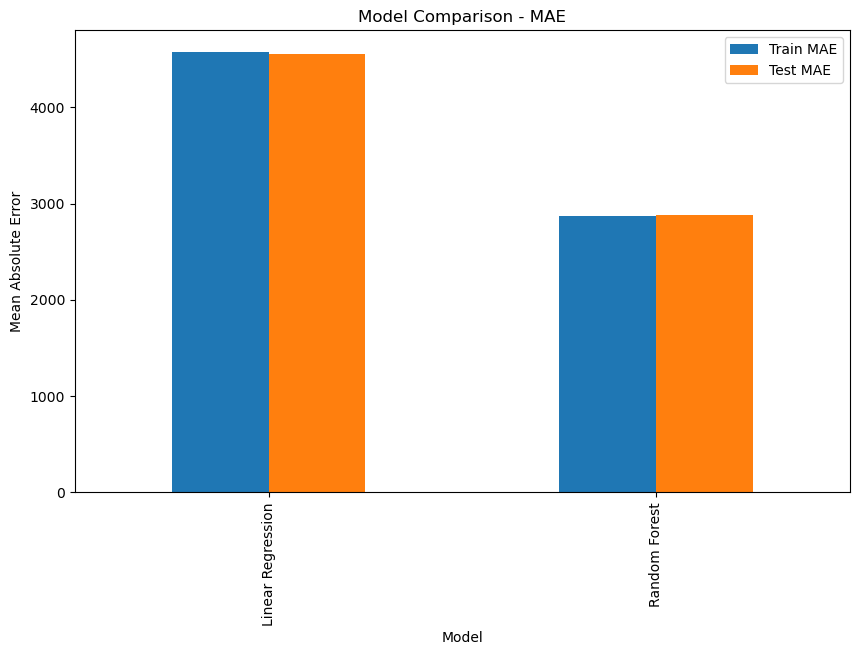

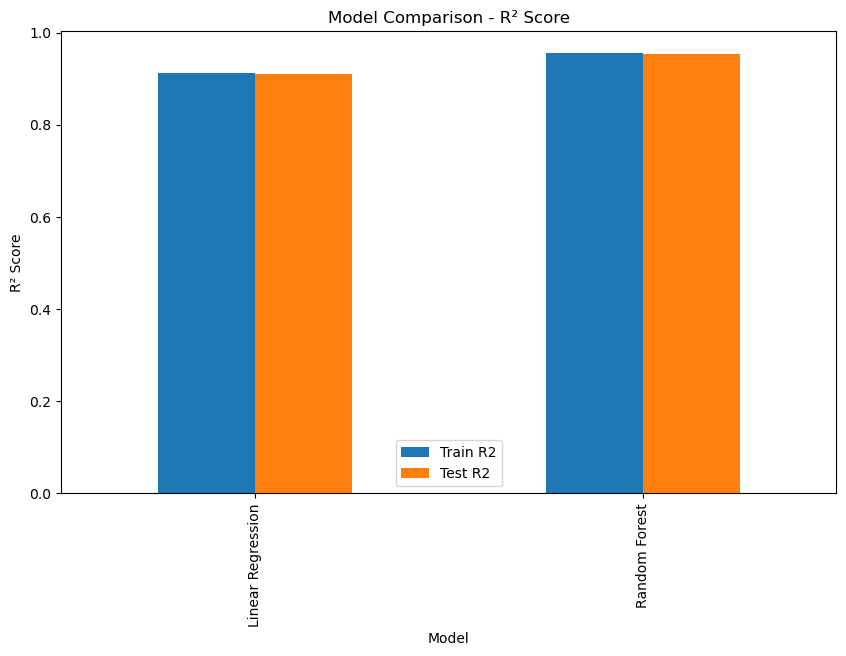

In [11]:
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'], 
    'Train MAE': [lr_train_mae, rf_train_mae], 
    'Test MAE': [lr_test_mae, rf_test_mae],
    'Train R2': [lr_train_r2, rf_train_r2],
    'Test R2': [lr_test_r2, rf_test_r2]
})

print(model_comparison)

# Visualize Comparison
comparison.set_index('Model', inplace=True)
comparison[['Train MAE', 'Test MAE']].plot(kind='bar', figsize=(10, 6), title="Model Comparison - MAE")
plt.ylabel("Mean Absolute Error")
plt.show()

comparison[['Train R2', 'Test R2']].plot(kind='bar', figsize=(10, 6), title="Model Comparison - R² Score")
plt.ylabel("R² Score")
plt.show()